In [1]:
import sys
import pickle 

sys.path.append(sys.path[0] + "/..")  # Adds higher directory to python modules path.

import numpy as np
from Functions import renormalize, scomplex, plotting, support
import matplotlib.pyplot as plt
import networkx as nx
import powerlaw as pwl
import seaborn as sns
import scipy
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams["text.usetex"] = False

import matplotlib.colors as mcolors

from matplotlib.colors import LinearSegmentedColormap
from pandas import DataFrame, read_csv

#colors = ["#071C56","#06418F","#2B589F","#5A5389","#7F588D","#533262","#B45389","#D75F78","#FDA599","#A40237"]
colors = ["#003F5C","#2F4B7C","#665191","#A05195","#D45087","#F95D6A","#FF7C43","#FFA600"]
colors_sequential = colors + colors + colors + colors 
colors = ["#02405c", "#fea600", "#a20655", "#5e96c5", "#4b3596", "#fa6ca9", "#8d6cf6"]
colors_curves = colors+ colors+ colors+ colors
#cmap = LinearSegmentedColormap.from_list("my_sas",colors)


In [65]:
names = ["asoiaf", "ego-facebook","subelj_euroroad_euroroad", "dimacs10-netscience",
         "arenas-email", "dimacs10-celegans_metabolic", "ecoli", "mmusculus", "drosophila"]
true_names = ["\emph{A Song of Ice and Fire}", "\emph{Facebook friendship}","\emph{E-road network}", "\emph{Co-authorship}", "\emph{Email}", "\emph{C. Elegans}", "\emph{E. Coli}", "\emph{M. Musculus}", "\emph{D. Melanogaster}"]
types = ['clique', 'inference']
laplacians_types = ["01","02","10","12","20","21"]

In [114]:
#Set the dataset and type
n = 5
typ = types[1]
if typ == 'clique':
    dataset = names[n]
elif typ == 'inference':
    dataset = f'{names[n]}_{typ}'
print(dataset)

dimacs10-celegans_metabolic_inference


# Generate Simplicial Complex

## Clique

In [45]:
f = open(f"../Datasets/out.{dataset}","r")
i = 0
edges = []
for line in f:
    if i != 0:
        words = line.split()
        edges.append((words[0],words[1]))
    else:
        i += 1
f.close()
G = nx.from_edgelist(edges)
G = nx.convert_node_labels_to_integers(G)
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
#Convert network into Simplicial Complex
sc = scomplex.convert_graph_to_sc(G,dim = 2, type = typ)
print('Nodes', sc['n0'], 'Edges', sc['n1'], 'Faces', sc['n2'])

Nodes 2888 Edges 2981 Faces 91


## Inference

In [115]:
#Load pre-saved Simplicial Complexes
with open(f'../Datasets/sc_inference.pickle', 'rb') as handle:
        sc_inf = pickle.load(handle)
#Set the repetition
#r = 0
sc = sc_inf[n]#[r]
#print('Nodes', sc['n0'], 'Edges', sc['n1'], 'Faces', sc['n2'])

## Built new Inferenced Simplicial Complex

### Build the network

In [21]:
#Building the networks of all real datasets
G_real_data = []
for n in range(6):
    
    dataset = names[n]
    print(dataset)
    f = open(f"../Datasets/out.{dataset}","r")

    i = 0
    edges = []
    for line in f:
        if i != 0:
            words = line.split()
            edges.append((words[0],words[1]))
        else:
            i += 1
    f.close()
    G = nx.from_edgelist(edges)
    G = nx.convert_node_labels_to_integers(G)
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    G_real_data.append(G)

asoiaf
ego-facebook
subelj_euroroad_euroroad
dimacs10-netscience
arenas-email
dimacs10-celegans_metabolic


### Convert in sc(inference)

In [22]:
sc_real_data = [] #Slow, already saved in Graphs
for n in range(6):
    sc = []
    print(names[n])
    for i in range(10):
        sc_inf = scomplex.convert_graph_to_sc(G_real_data[n], dim = 2, type='inference')
        sc.append(sc_inf)
    sc_real_data.append(sc)

asoiaf
ego-facebook
subelj_euroroad_euroroad
dimacs10-netscience
arenas-email
dimacs10-celegans_metabolic


### Save Simplicial Complex

In [117]:
with open(f'../Datasets/sc_inference.pickle', 'wb') as handle:
    pickle.dump(sc_real_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load Simplicial Complex

In [119]:
with open(f'../Datasets/sc_inference.pickle', 'rb') as handle:
        sc_inf = pickle.load(handle)

## Plot complex

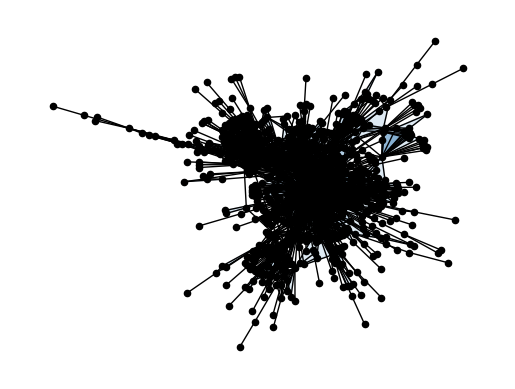

In [128]:
# Plot simplicial complex (might be slow)
f,ax = plt.subplots(1,1)
plotting.plot_complex(sc_inf[0][2],ax = ax,face_color=[colors[3]],layout = "spring", iterations = 100, node_size=20)


# Statistical physics of information diffusion

### Compute Sp Heats

In [104]:
def compute_spectral_d(D,taumin,taumax,ntau):
    tau_space = np.logspace(taumin, taumax, num=ntau)
    Z = np.zeros(ntau)
    for t in range(ntau):
        Z[t] = np.sum(np.exp(- tau_space[t]*D))

    dS = -2*np.diff(np.log(Z))/np.diff(np.log(tau_space))
    return dS, tau_space[1:]

In [112]:
n = 5
dataset = names[n]
for r in range(10):
    print('rep', r)
    sc = sc_real_data[n][i]
    
    sparse = False
    num_eigs = 500
    # Define strings which specify the Laplacians to consider
    laplacians_types = ["01","02","10","12","20","21"]
    #laplacians_types = ["01","10"]
    #laplacians_types = ["01","02","12"]
    #laplacians_types = ["01","03","13","23"]
    #laplacians_types = ["01","04","14","24","34"]
    Laplacians = []
    for l in laplacians_types:    
        L = scomplex.diffusion_laplacian(sc, k=int(l[0]), l=int(l[1]),sparse = sparse)
        # # Configuration model
        # A = scomplex.diffusion_laplacian(sc, k=int(l[0]), l=int(l[1]),sparse = sparse)
        # Gcm = nx.Graph(A)
        # Gcm = nx.configuration_model([val for (node, val) in G.degree()])
        # L = nx.laplacian_matrix(Gcm).todense()
        Laplacians.append(L)
    # Compute eigenvalues of the Laplacians and their specific heat curves
    taumin = -5 # Heat curve starts from 10**taumin
    taumax = 5 # Heat curve ends at 10**taumax
    ntau = 200 # Number of taus to consider in the interval
    
    eigs = []
    sp_heats = []
    sp_dims = []
    
    for i in range(len(Laplacians)):
        print(i)
        L = Laplacians[i]
        if sparse:
            D,U = scipy.sparse.linalg.eigsh(L.asfptype(),k = num_eigs, which = "SM")
            D = np.append(D,1000000*np.ones(L.shape[0]-num_eigs),axis=0)
        else:
            D,U = np.linalg.eigh(L)
            D = np.abs(D)
        specific_heat,tau_space, __ = renormalize.compute_heat(D,taumin,taumax,ntau)
        spectral_dimension,tau_space = compute_spectral_d(D,taumin,taumax,ntau)
        sp_heats.append(specific_heat)
        sp_dims.append(spectral_dimension)
        eigs.append(D)
        
    #with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats_inf/{dataset}/sp_heats_rep{r}.pickle', 'wb') as handle:
        #pickle.dump(sp_heats, handle, protocol=pickle.HIGHEST_PROTOCOL)


rep 0
0
1
2
3
4
5
rep 1
0
1
2
3
4
5
rep 2
0
1
2
3
4
5
rep 3
0
1
2
3
4
5
rep 4
0
1
2
3
4
5
rep 5
0
1
2
3
4
5
rep 6
0
1
2
3
4
5
rep 7
0
1
2
3
4
5
rep 8
0
1
2
3
4
5
rep 9
0
1
2
3
4
5


### Load SP Heats

In [116]:
sp_heats =[]
if typ == 'clique':
    with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats/{dataset}_sp_heats.pickle', 'rb') as handle:
        sp_heats = pickle.load(handle)
if typ == 'inference':
    for r in range(10):
        with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats_inf/{names[n]}/sp_heats_rep{r}.pickle', 'rb') as handle:
            sp = pickle.load(handle)
        sp_heats.append(sp)
d = int((-1+np.sqrt(1+4*len(sp_heats)))/2)        
laplacians_types = [f"{k}{m}" for k in range(d+1) for m in range(d+1) if m!=k]        
tau_space = np.logspace(-5,5,200)[:200-1]
print('Dim', d, 'Laplacians', laplacians_types, 'tau_space', len(tau_space))

Dim 2 Laplacians ['01', '02', '10', '12', '20', '21'] tau_space 199


## Plot graph

### Curves plot for paper

In [241]:
#Set the dataset you want to show
names = ["asoiaf", "ego-facebook","subelj_euroroad_euroroad", "dimacs10-netscience", "arenas-email", "dimacs10-celegans_metabolic"]
n = 5
dataset = names[n]
print(dataset)

dimacs10-celegans_metabolic


In [242]:
#Select the sp_heats of the 10 repetition of this dataset
sp_heats_dataset = sp_heats_inf[n]
#Check the length
print(len(sp_heats_dataset))

10


In [117]:
#Compute the average
sp_heats_av = [sum(sub_list) / len(sub_list) for sub_list in zip(*sp_heats)]

### Plot all the repetition with average

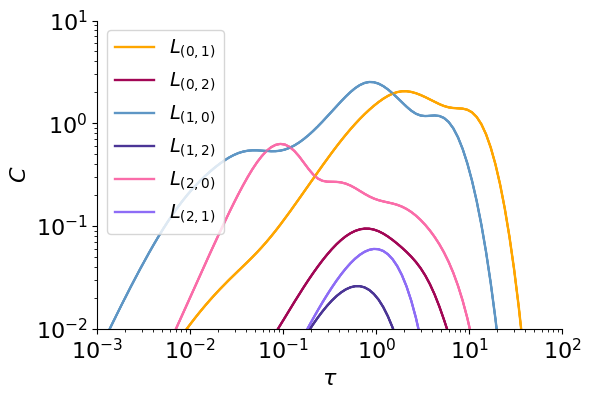

In [118]:
#Plot the Sp Heats Curves 
names_laplacians = [f"$L_{{({int(l[0])},{int(l[1])})}}$" for l in laplacians_types]
f,ax = plt.subplots(1,1,figsize = (6,4))
#Plot the average
for i in range(len(laplacians_types)):
    if i != 3:
        alph = 1
    else:
        alph = 1
    ax.loglog(tau_space,sp_heats_av[i],color = colors_curves[i+1],linewidth = 1.7,alpha = alph)

#Plot the repetitions
for r in range(10):
    for i in range(len(laplacians_types)):
        if i != 3:
            alph = 1
        else:
            alph = 1
        ax.loglog(tau_space,sp_heats[r][i],color = colors_curves[i+1],linewidth = 1.3,alpha = 0.3)

ax.set_ylim([10**-2,10**1])
ax.set_xlim([10**-3,10**2])
ax.legend(names_laplacians,fontsize = 14)
ax.set_xlabel(r"$\tau$",fontsize = 16)
ax.set_ylabel(r"$C$",fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

#ax.hlines(y = 0.8,xmin=0.2,xmax = 700,linestyles='--',color = [0.5,0.5,0.5])
sns.despine()
plt.savefig(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats_inf/{dataset}_curves_average.pdf',bbox_inches="tight")


### Plot only average

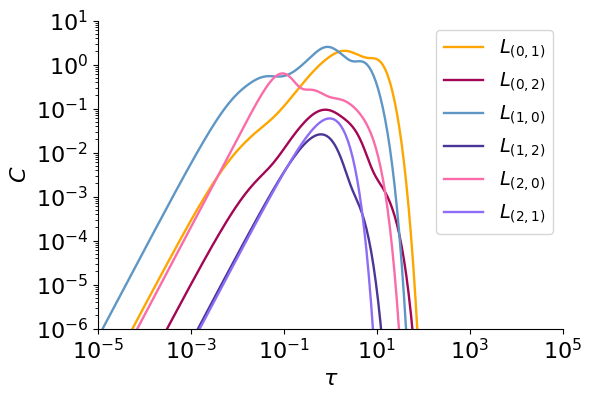

In [244]:
#Plot only the average
names_laplacians = [f"$L_{{({int(l[0])},{int(l[1])})}}$" for l in laplacians_types]
f,ax = plt.subplots(1,1,figsize = (6,4))
#Plot the average
for i in range(len(laplacians_types)):
    if i != 3:
        alph = 1
    else:
        alph = 1
    ax.loglog(tau_space,sp_heats_av[i],color = colors_curves[i+1],linewidth = 1.7,alpha = alph)

ax.set_ylim([10**-6,10**1])
ax.set_xlim([10**-5,10**5])
ax.legend(names_laplacians,fontsize = 14)
ax.set_xlabel(r"$\tau$",fontsize = 16)
ax.set_ylabel(r"$C$",fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

#ax.hlines(y = 0.8,xmin=0.2,xmax = 700,linestyles='--',color = [0.5,0.5,0.5])
sns.despine()
plt.savefig(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/{dataset}_inference_curves.pdf')


# Renormalize Real Data

In [7]:
#Set the %of nodes to remove
frac_nodes_remove = 25
print('Remove at least', frac_nodes_remove, '% of nodes')

Remove at least 25 % of nodes


In [8]:
sc_renorm = {}
tau_renorm = {}
for lt in laplacians_types:
    sc_renorm[lt] = []
    tau_renorm[lt] = []

## L(0,1) - always

In [16]:
lmax = 2
diff_order = 0
int_order = 1
tau = .066
PLOT = False # Plotting might be very slow
VERBOSE = True

sequence = renormalize.renormalize_steps(sc,lmax = lmax,tau = tau, diff_order = diff_order, int_order = int_order, PLOT = PLOT, VERBOSE = VERBOSE, SAVENAME = None)
N0 = sequence[0]['n0']
N1 = sequence[1]['n0']
frac_removed = (N0-N1)/N0*100
print(f'The ({diff_order},{int_order})-renormalization with tau =', tau, 'has removed', round(frac_removed,2), '% of nodes')

Nref = sequence[1]['n0']

sc_renorm[f'{diff_order}{int_order}'] = sequence
tau_renorm[f'{diff_order}{int_order}'] = tau

796
591
The (0,1)-renormalization with tau = 0.066 has removed 25.75 % of nodes


## L(k,m)

In [50]:
lmax = 2
k = 2
m = 1
tau = .5
PLOT = False # Plotting might be very slow
VERBOSE = True

sequence = renormalize.renormalize_steps(sc,lmax = lmax,tau = tau, diff_order = k, int_order = m, PLOT = PLOT, VERBOSE = VERBOSE, SAVENAME = None)
N0 = sequence[0]['n0']
N1 = sequence[1]['n0']
frac_removed = (N0-N1)/N0*100
print(f'The ({k},{m})-renormalization with tau =', tau, 'has removed', round(frac_removed,2), '% of nodes')

sc_renorm[f'{k}{m}'] = sequence
tau_renorm[f'{k}{m}'] = tau

796
712
The (2,1)-renormalization with tau = 0.5 has removed 10.55 % of nodes


# Comparison

In [51]:
#Set the sp_heat to compute
diff_order = 1
int_order = 0
taumin = -5
taumax = 5
ntau = 200
nodes = np.zeros(lmax)
Ds = []
spheats_renorm = {}
for lt in laplacians_types:
    spheats_renorm[lt] = []
i = lmax-1 #final step of renormalization

### L(0,1) - always

In [52]:
scc = sc_renorm['01'][i]
nodes[i] = scc["n0"]
Lnew = scomplex.diffusion_laplacian(scc, diff_order, int_order)

Dnew, Unew = np.linalg.eigh(Lnew)
Ds.append(Dnew)
specific_heat,tau_space, __ = renormalize.compute_heat(Dnew,taumin,taumax,ntau)
spheats_renorm['01'] = specific_heat

/Users/martamorandini/Desktop/Simplicial_Renormalization/hodge_renormalization/Hodge_renorm/Experiments_setups/../Functions/renormalize.py:305: RuntimeWarning: overflow encountered in exp
  mu[i] = 1 / np.sum(np.exp(-tau * (D - D[i])))
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### L(k,m)

In [55]:
k = 2
m = 0
scc = sc_renorm[f'{k}{m}'][i]
nodes[i] = scc["n0"]
Lnew = scomplex.diffusion_laplacian(scc, diff_order, int_order)

Dnew, Unew = np.linalg.eigh(Lnew)
Ds.append(Dnew)
specific_heat,tau_space, __ = renormalize.compute_heat(Dnew,taumin,taumax,ntau)
spheats_renorm[f'{k}{m}'] = specific_heat

### Plot the original and renormalized sp_heat

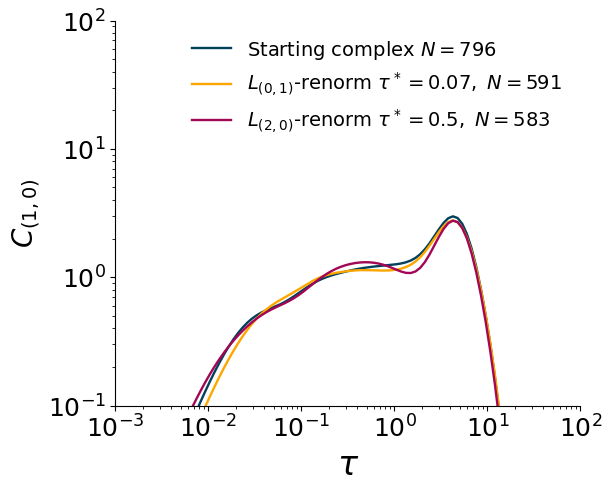

In [60]:
Ni = sc['n0']
f,ax = plt.subplots(1,1,figsize = (6,5))
ax.loglog(tau_space, sp_heats[laplacians_types.index(f'{diff_order}{int_order}')], color = colors_curves[0], linewidth = 1.7, 
          label = "Starting complex" + f" $N = {Ni}$ ")
c=1
for k, m in [(0,1),(2,0)]: #permutations([0,1,2],2):
    ax.loglog(tau_space, spheats_renorm[f'{k}{m}'],color = colors_curves[c],linewidth = 1.7,
          label = f"$L_{{({k},{m})}}$-renorm"+r" $\tau^* = $"+f"${np.round((tau_renorm[f'{k}{m}']),2)},$" + f" $N = {(sc_renorm[f'{k}{m}'][i]['n0'])}$ ")
    c+=1
ax.set_ylim([10**-1,10**2])
ax.set_xlim([10**-3,10**2])
ax.legend(fontsize = 14, loc = 'upper right', frameon = False)
ax.set_xlabel(r"$\tau$",fontsize = 24)

ax.set_ylabel(f"$C_{{({diff_order},{int_order})}}$",fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
#ax.hlines(y = 1,xmin=5,xmax = 800,linestyles='--',color = [0.5,0.5,0.5])
sns.despine()
#plt.savefig(f"../Experiments_results/Diffusion_Laplacians/Renormalizations/RealData/renormalize_{dataset}_C_{diff_order}{int_order}.pdf",bbox_inches="tight")

## Plot the degree distributions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


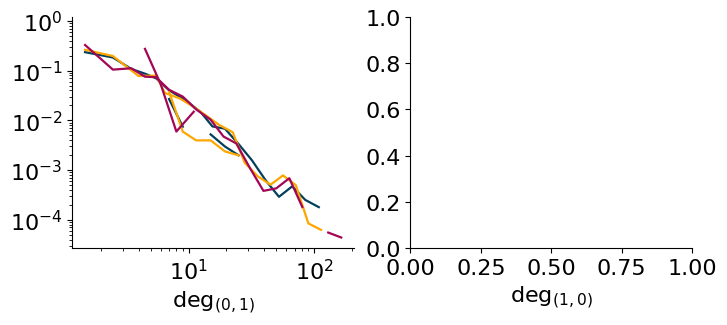

In [64]:
d = 2
f,axs = plt.subplots(1,d,figsize = (4*(d),3))
c=0
#Plot originals deg distr
for (dim, d) in [(0,1), (0,2)]:
    A = scomplex.adjacency_of_order(sc,dim,d)
    deg = np.sum(A,0)#/(scipy.special.comb(d+1,i+1)-1)
    pwl.plot_pdf(deg[deg>0],ax = axs[dim],linewidth = 1.6,
                 color = colors_curves[c], label = 'Original')
#Plot renormalized deg distr
c = 1
for (k, m) in [(0,1), (2,0)]: #permutations([0,1,2],2):
    sc2 = sc_renorm[f'{k}{m}'][i]
    for dim, d in [(0,1), (0,2)]:
        A = scomplex.adjacency_of_order(sc2,dim,d)
        deg = np.sum(A,0)#/(scipy.special.comb(d+1,i+1)-1)
        pwl.plot_pdf(deg[deg>0],ax = axs[dim],linewidth = 1.6, linestyle = '-',
                     color = colors_curves[c], label = '$L_{('+ str(dim) + ',' + str(d) + ')}$-renorm')
    c+=1
plt.legend( frameon = False)
for k, m in [(0,1), (1,0)]:
    axs[k].set_xlabel(r"$\mathrm{deg}_"+f"{{({k},{m})}}$",fontsize = 16)
    axs[k].xaxis.set_tick_params(labelsize=16)
    axs[k].yaxis.set_tick_params(labelsize=16)
   


sns.despine()
#plt.savefig(f"../Experiments_results/Diffusion_Laplacians/Renormalizations/RealData/{dataset}_renorm_degrees_C_{diff_order}{int_order}.pdf",bbox_inches="tight")
